In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd, csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from zipfile import ZipFile
from itertools import count
from scipy.spatial import distance_matrix
import seaborn as sns

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

In [ ]:
submissions = "/content/drive/MyDrive/CIS 5450/submissions_cleaned.csv"
reddit = pd.read_csv(submissions, parse_dates=["created"])

# **Classification of Data**

In [ ]:
len(reddit)

381664

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
sid = SentimentIntensityAnalyzer()

In [ ]:
df_posts = reddit

In [ ]:
#get the polarity scores of the text 
df_posts['score'] = df_posts['text'].apply(lambda text: sid.polarity_scores(str(text)))

In [ ]:
#get the compounded scores from the score column
df_posts['compound']  = df_posts['score'].apply(lambda score_dict: score_dict['compound'])

In [ ]:
#use compound scores to perform a ranking on the sentiment in 3 categories, positive, negative
df_posts['sentiment'] = df_posts['compound'].apply(lambda c: 'positive' if c > 0 else('negative' if c < 0 else 'neutral'))

In [ ]:
df_posts.dtypes

id                         int64
subreddit_name            object
text                      object
author_name               object
score                     object
up_votes                   int64
down_votes                 int64
created           datetime64[ns]
awards                    object
url                       object
compound                 float64
sentiment                 object
dtype: object

In [ ]:
#isolate only core columns and proceed
posts = df_posts[['subreddit_name', 'text', 'sentiment']]

In [ ]:
df_posts["sentiment"].unique()
posts.groupby(['subreddit_name', 'sentiment']).nunique()

text
subreddit_name sentiment       
berkeley       negative   14562
               neutral    12515
               positive   27140
brownu         negative    1631
               neutral     2344
               positive    8398
caltech        negative     449
               neutral      747
               positive    3200
cmu            negative    3698
               neutral     4536
               positive   14011
columbia       negative    5311
               neutral     5425
               positive   14049
cornell        negative    3554
               neutral     2307
               positive    5629
dartmouth      negative    1002
               neutral     1808
               positive    6119
gatech         negative   12332
               neutral    11135
               positive   25951
harvard        negative    3121
               neutral     4322
               positive   11682
mit            negative    2846
               neutral     3347
               positive   10893
princeton      negative    1134
               neutral     1775
               positive    5594
stanford       negative    3170
               neutral     3993
               positive   12391
uchicago       negative    4357
               neutral     5144
               positive   14964
uiuc           negative   13266
               neutral    12674
               positive   25287
upenn          negative    4264
               neutral     5447
               positive   12886
yale           negative    2009
               neutral     2377
               positive    8087

# **Label Encoding**

In [ ]:
import tensorflow as tf

In [ ]:
smaller_df = posts[['subreddit_name','text', 'sentiment']]

# **Cluster 1 - Upenn, Columbia, Uchicago**

In [ ]:
posts['subreddit_name'].unique()

array(['upenn', 'princeton', 'mit', 'harvard', 'stanford', 'yale',
       'uchicago', 'caltech', 'brownu', 'columbia', 'cornell',
       'dartmouth', 'cmu', 'uiuc', 'berkeley', 'gatech'], dtype=object)

In [ ]:
penn = posts.loc[posts['subreddit_name'] == 'upenn']
columbia = posts.loc[posts['subreddit_name'] == 'columbia']
uchicago = posts.loc[posts['subreddit_name'] == 'uchicago']

# A. Upenn

In [ ]:
#convert sentiments to numerical value
labels = np.array(penn['sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neutral':
        y.append(0)
    if labels[i] == 'negative':
        y.append(1)
    if labels[i] == 'positive':
        y.append(2)

y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

In [ ]:
#splitting
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(penn["text"])
sequences = tokenizer.texts_to_sequences(penn["text"])
reddit_posts = pad_sequences(sequences, maxlen=max_len)
print(reddit_posts)

X_train, X_test, y_train, y_test = train_test_split(reddit_posts, labels, random_state = 0)
print (len(X_train),len(X_test),len(y_train),len(y_test)) 

[[   0    0    0 ... 1966 4018  872]
 [   0    0    0 ...   69  134 3312]
 [   0    0    0 ...    0   16    9]
 ...
 [   0    0    0 ...  580   75  229]
 [   0    0    0 ...  482  414 2907]
 [   0    0    0 ...  504 1068  101]]
17725 5909 17725 5909


In [ ]:
#ltsm model
model = Sequential()
model.add(layers.Embedding(max_words, 40, input_length=max_len))
model.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model.add(layers.Dense(3,activation='softmax'))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#checkpoints enure the best metric is saved during training
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model.fit(X_train, y_train, epochs=30,validation_data=(X_test, y_test),callbacks=[checkpoint2])

Epoch 1/30
554/554 [==============================] - ETA: 0s - loss: 0.7789 - accuracy: 0.6623
Epoch 1: val_accuracy improved from -inf to 0.73532, saving model to best_model2.hdf5
554/554 [==============================] - 120s 150ms/step - loss: 0.7789 - accuracy: 0.6623 - val_loss: 0.6379 - val_accuracy: 0.7353
Epoch 2/30
554/554 [==============================] - ETA: 0s - loss: 0.5782 - accuracy: 0.7621
Epoch 2: val_accuracy improved from 0.73532 to 0.77932, saving model to best_model2.hdf5
554/554 [==============================] - 81s 147ms/step - loss: 0.5782 - accuracy: 0.7621 - val_loss: 0.5447 - val_accuracy: 0.7793
Epoch 3/30
554/554 [==============================] - ETA: 0s - loss: 0.4859 - accuracy: 0.8128
Epoch 3: val_accuracy improved from 0.77932 to 0.81469, saving model to best_model2.hdf5
554/554 [==============================] - 84s 151ms/step - loss: 0.4859 - accuracy: 0.8128 - val_loss: 0.4694 - val_accuracy: 0.8147
Epoch 4/30
554/554 [=========================

In [ ]:
#Try CNN implementation and compare 
from keras import regularizers
model3 = Sequential()
model3.add(layers.Embedding(max_words, 40, input_length=max_len))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.MaxPooling1D(5))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(3,activation='softmax'))
model3.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])
checkpoint3 = ModelCheckpoint("best_model3.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model3.fit(X_train, y_train, epochs=30,validation_data=(X_test, y_test),callbacks=[checkpoint3])

Epoch 1/30
552/554 [============================>.] - ETA: 0s - loss: 1.0047 - acc: 0.6292

554/554 [==============================] - 14s 23ms/step - loss: 1.0037 - acc: 0.6296 - val_loss: 0.7716 - val_acc: 0.7323
Epoch 2/30
554/554 [==============================] - ETA: 0s - loss: 0.6929 - acc: 0.7616

554/554 [==============================] - 12s 21ms/step - loss: 0.6929 - acc: 0.7616 - val_loss: 0.6748 - val_acc: 0.7594
Epoch 3/30
552/554 [============================>.] - ETA: 0s - loss: 0.6202 - acc: 0.7814

554/554 [==============================] - 12s 22ms/step - loss: 0.6201 - acc: 0.7814 - val_loss: 0.6196 - val_acc: 0.7758
Epoch 4/30
554/554 [==============================] - ETA: 0s - loss: 0.5799 - acc: 0.7954

554/554 [==============================] - 14s 25ms/step - loss: 0.5799 - acc: 0.7954 - val_loss: 0.6008 - val_acc: 0.7808
Epoch 5/30
553/554 [============================>.] - ETA: 0s - loss: 0.5585 - acc: 0.8073

554/554 [==============================] - 12s 22ms/step - loss: 0.5583 - acc: 0.8074 - val_loss: 0.5840 - val_acc: 0.7883
Epoch 6/30
554/554 [==============================] - ETA: 0s - loss: 0.5418 - acc: 0.8128

554/554 [==============================] - 14s 25ms/step - loss: 0.5418 - acc: 0.8128 - val_loss: 0.5738 - val_acc: 0.7915
Epoch 7/30
554/554 [==============================] - ETA: 0s - loss: 0.5299 - acc: 0.8188

554/554 [==============================] - 12s 21ms/step - loss: 0.5299 - acc: 0.8188 - val_loss: 0.5726 - val_acc: 0.8000
Epoch 8/30
552/554 [============================>.] - ETA: 0s - loss: 0.5199 - acc: 0.8247

554/554 [==============================] - 14s 25ms/step - loss: 0.5193 - acc: 0.8250 - val_loss: 0.5637 - val_acc: 0.7979
Epoch 9/30
552/554 [============================>.] - ETA: 0s - loss: 0.5099 - acc: 0.8243

554/554 [==============================] - 12s 22ms/step - loss: 0.5098 - acc: 0.8243 - val_loss: 0.5565 - val_acc: 0.8176
Epoch 10/30
554/554 [==============================] - ETA: 0s - loss: 0.4993 - acc: 0.8308

554/554 [==============================] - 12s 22ms/step - loss: 0.4993 - acc: 0.8308 - val_loss: 0.5484 - val_acc: 0.8061
Epoch 11/30
554/554 [==============================] - ETA: 0s - loss: 0.4875 - acc: 0.8359

554/554 [==============================] - 14s 25ms/step - loss: 0.4875 - acc: 0.8359 - val_loss: 0.5459 - val_acc: 0.8103
Epoch 12/30
552/554 [============================>.] - ETA: 0s - loss: 0.4734 - acc: 0.8413

554/554 [==============================] - 12s 22ms/step - loss: 0.4732 - acc: 0.8415 - val_loss: 0.5351 - val_acc: 0.8164
Epoch 13/30
554/554 [==============================] - ETA: 0s - loss: 0.4599 - acc: 0.8483

554/554 [==============================] - 12s 22ms/step - loss: 0.4599 - acc: 0.8483 - val_loss: 0.5334 - val_acc: 0.8243
Epoch 14/30
553/554 [============================>.] - ETA: 0s - loss: 0.4444 - acc: 0.8604

554/554 [==============================] - 14s 25ms/step - loss: 0.4451 - acc: 0.8603 - val_loss: 0.5443 - val_acc: 0.8201
Epoch 15/30
554/554 [==============================] - ETA: 0s - loss: 0.4238 - acc: 0.8711

554/554 [==============================] - 12s 22ms/step - loss: 0.4238 - acc: 0.8711 - val_loss: 0.5035 - val_acc: 0.8428
Epoch 16/30
554/554 [==============================] - ETA: 0s - loss: 0.3979 - acc: 0.8838

554/554 [==============================] - 12s 22ms/step - loss: 0.3979 - acc: 0.8838 - val_loss: 0.4787 - val_acc: 0.8516
Epoch 17/30
553/554 [============================>.] - ETA: 0s - loss: 0.3785 - acc: 0.8917

554/554 [==============================] - 14s 25ms/step - loss: 0.3782 - acc: 0.8918 - val_loss: 0.4734 - val_acc: 0.8611
Epoch 18/30
553/554 [============================>.] - ETA: 0s - loss: 0.3634 - acc: 0.8959

554/554 [==============================] - 12s 22ms/step - loss: 0.3634 - acc: 0.8960 - val_loss: 0.4734 - val_acc: 0.8595
Epoch 19/30
553/554 [============================>.] - ETA: 0s - loss: 0.3523 - acc: 0.9022

554/554 [==============================] - 14s 25ms/step - loss: 0.3524 - acc: 0.9022 - val_loss: 0.4591 - val_acc: 0.8639
Epoch 20/30
552/554 [============================>.] - ETA: 0s - loss: 0.3424 - acc: 0.9045

554/554 [==============================] - 12s 22ms/step - loss: 0.3424 - acc: 0.9045 - val_loss: 0.4449 - val_acc: 0.8663
Epoch 21/30
553/554 [============================>.] - ETA: 0s - loss: 0.3334 - acc: 0.9104

554/554 [==============================] - 12s 22ms/step - loss: 0.3332 - acc: 0.9105 - val_loss: 0.4469 - val_acc: 0.8685
Epoch 22/30
554/554 [==============================] - ETA: 0s - loss: 0.3256 - acc: 0.9128

554/554 [==============================] - 13s 24ms/step - loss: 0.3256 - acc: 0.9128 - val_loss: 0.4463 - val_acc: 0.8670
Epoch 23/30
552/554 [============================>.] - ETA: 0s - loss: 0.3167 - acc: 0.9167

554/554 [==============================] - 12s 22ms/step - loss: 0.3165 - acc: 0.9167 - val_loss: 0.4444 - val_acc: 0.8653
Epoch 24/30
554/554 [==============================] - ETA: 0s - loss: 0.3090 - acc: 0.9202

554/554 [==============================] - 12s 22ms/step - loss: 0.3090 - acc: 0.9202 - val_loss: 0.4466 - val_acc: 0.8683
Epoch 25/30
554/554 [==============================] - ETA: 0s - loss: 0.3026 - acc: 0.9221

554/554 [==============================] - 14s 25ms/step - loss: 0.3026 - acc: 0.9221 - val_loss: 0.4453 - val_acc: 0.8673
Epoch 26/30
553/554 [============================>.] - ETA: 0s - loss: 0.2943 - acc: 0.9256

554/554 [==============================] - 12s 22ms/step - loss: 0.2944 - acc: 0.9254 - val_loss: 0.4537 - val_acc: 0.8690
Epoch 27/30
553/554 [============================>.] - ETA: 0s - loss: 0.2881 - acc: 0.9291

554/554 [==============================] - 14s 25ms/step - loss: 0.2880 - acc: 0.9291 - val_loss: 0.4578 - val_acc: 0.8639
Epoch 28/30
554/554 [==============================] - ETA: 0s - loss: 0.2821 - acc: 0.9313

554/554 [==============================] - 12s 22ms/step - loss: 0.2821 - acc: 0.9313 - val_loss: 0.4504 - val_acc: 0.8644
Epoch 29/30
554/554 [==============================] - ETA: 0s - loss: 0.2763 - acc: 0.9340

554/554 [==============================] - 14s 26ms/step - loss: 0.2763 - acc: 0.9340 - val_loss: 0.4497 - val_acc: 0.8646
Epoch 30/30
553/554 [============================>.] - ETA: 0s - loss: 0.2706 - acc: 0.9367

554/554 [==============================] - 12s 22ms/step - loss: 0.2706 - acc: 0.9366 - val_loss: 0.4635 - val_acc: 0.8656


In [ ]:
import keras

In [ ]:
#Let's load the best model obtained during training
best_model = keras.models.load_model("best_model2.hdf5")

In [ ]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

185/185 - 5s - loss: 0.3562 - accuracy: 0.8873 - 5s/epoch - 27ms/step
Model accuracy:  0.8872905969619751


In [ ]:
predictions = best_model.predict(X_test)

185/185 [==============================] - 5s 25ms/step


<ipython-input-40-1464592c3a2e>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


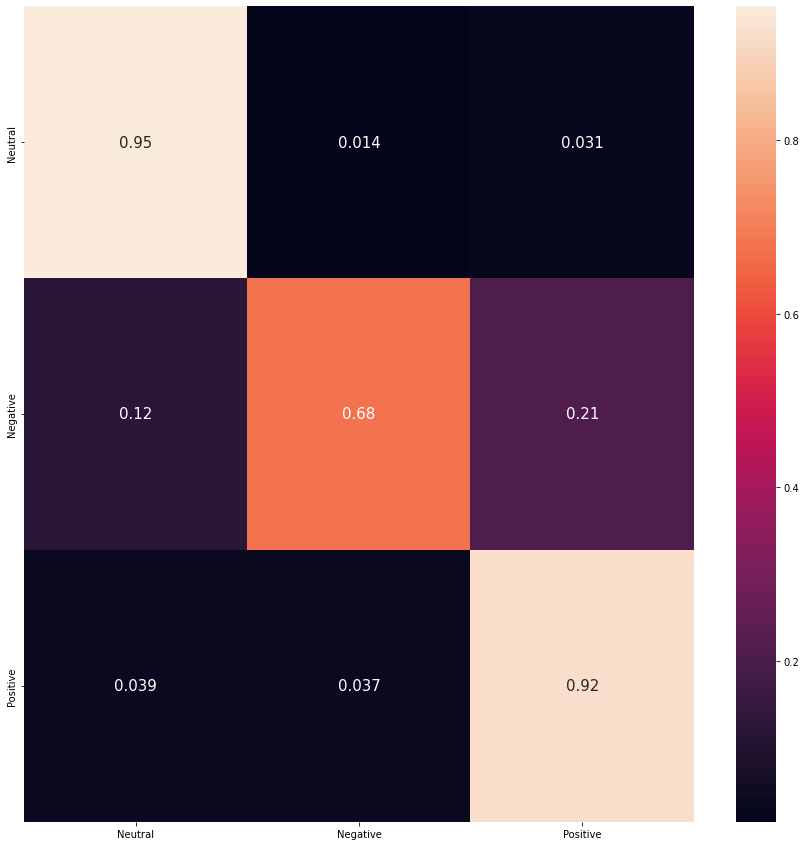

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

# Columbia

In [ ]:
#convert sentiments to numerical value
labels = np.array(columbia['sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neutral':
        y.append(0)
    if labels[i] == 'negative':
        y.append(1)
    if labels[i] == 'positive':
        y.append(2)

y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

In [ ]:
#splitting
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(columbia["text"])
sequences = tokenizer.texts_to_sequences(columbia["text"])
reddit_posts = pad_sequences(sequences, maxlen=max_len)
print(reddit_posts)

X_train, X_test, y_train, y_test = train_test_split(reddit_posts, labels, random_state = 0)
print (len(X_train),len(X_test),len(y_train),len(y_test)) 

[[   0    0    0 ...  949    6   61]
 [   0    0    0 ...   94  802  282]
 [   0    0    0 ... 1888  194  116]
 ...
 [   0    0    0 ...  369 2314  501]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...   61  303  937]]
19650 6550 19650 6550


In [ ]:
#ltsm model
model = Sequential()
model.add(layers.Embedding(max_words, 40, input_length=max_len))
model.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model.add(layers.Dense(3,activation='softmax'))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#checkpoints enure the best metric is saved during training
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model.fit(X_train, y_train, epochs=30,validation_data=(X_test, y_test),callbacks=[checkpoint2])

Epoch 1/30
615/615 [==============================] - ETA: 0s - loss: 0.7845 - accuracy: 0.6535
Epoch 1: val_accuracy improved from -inf to 0.72840, saving model to best_model2.hdf5
615/615 [==============================] - 88s 133ms/step - loss: 0.7845 - accuracy: 0.6535 - val_loss: 0.6365 - val_accuracy: 0.7284
Epoch 2/30
615/615 [==============================] - ETA: 0s - loss: 0.5845 - accuracy: 0.7584
Epoch 2: val_accuracy improved from 0.72840 to 0.76840, saving model to best_model2.hdf5
615/615 [==============================] - 79s 129ms/step - loss: 0.5845 - accuracy: 0.7584 - val_loss: 0.5459 - val_accuracy: 0.7684
Epoch 3/30
615/615 [==============================] - ETA: 0s - loss: 0.4871 - accuracy: 0.8089
Epoch 3: val_accuracy improved from 0.76840 to 0.81466, saving model to best_model2.hdf5
615/615 [==============================] - 79s 129ms/step - loss: 0.4871 - accuracy: 0.8089 - val_loss: 0.4848 - val_accuracy: 0.8147
Epoch 4/30
615/615 [==========================

In [ ]:
#Try CNN implementation and compare 
from keras import regularizers
model3 = Sequential()
model3.add(layers.Embedding(max_words, 40, input_length=max_len))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.MaxPooling1D(5))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(3,activation='softmax'))
model3.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])
checkpoint3 = ModelCheckpoint("best_model3.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model3.fit(X_train, y_train, epochs=30,validation_data=(X_test, y_test),callbacks=[checkpoint3])

Epoch 1/30
614/615 [============================>.] - ETA: 0s - loss: 0.9939 - acc: 0.6319

615/615 [==============================] - 36s 53ms/step - loss: 0.9938 - acc: 0.6320 - val_loss: 0.7514 - val_acc: 0.7226
Epoch 2/30
613/615 [============================>.] - ETA: 0s - loss: 0.6937 - acc: 0.7491

615/615 [==============================] - 16s 26ms/step - loss: 0.6934 - acc: 0.7493 - val_loss: 0.6665 - val_acc: 0.7518
Epoch 3/30
615/615 [==============================] - ETA: 0s - loss: 0.6299 - acc: 0.7670

615/615 [==============================] - 14s 23ms/step - loss: 0.6299 - acc: 0.7670 - val_loss: 0.6306 - val_acc: 0.7600
Epoch 4/30
613/615 [============================>.] - ETA: 0s - loss: 0.5878 - acc: 0.7845

615/615 [==============================] - 16s 26ms/step - loss: 0.5882 - acc: 0.7844 - val_loss: 0.6005 - val_acc: 0.7733
Epoch 5/30
612/615 [============================>.] - ETA: 0s - loss: 0.5617 - acc: 0.7977

615/615 [==============================] - 14s 22ms/step - loss: 0.5618 - acc: 0.7976 - val_loss: 0.6069 - val_acc: 0.7744
Epoch 6/30
613/615 [============================>.] - ETA: 0s - loss: 0.5463 - acc: 0.8066

615/615 [==============================] - 16s 26ms/step - loss: 0.5462 - acc: 0.8067 - val_loss: 0.5749 - val_acc: 0.7942
Epoch 7/30
613/615 [============================>.] - ETA: 0s - loss: 0.5339 - acc: 0.8181

615/615 [==============================] - 14s 23ms/step - loss: 0.5337 - acc: 0.8181 - val_loss: 0.5702 - val_acc: 0.8003
Epoch 8/30
614/615 [============================>.] - ETA: 0s - loss: 0.5223 - acc: 0.8195

615/615 [==============================] - 18s 29ms/step - loss: 0.5222 - acc: 0.8195 - val_loss: 0.5597 - val_acc: 0.8061
Epoch 9/30
613/615 [============================>.] - ETA: 0s - loss: 0.5127 - acc: 0.8291

615/615 [==============================] - 14s 22ms/step - loss: 0.5125 - acc: 0.8293 - val_loss: 0.5569 - val_acc: 0.8043
Epoch 10/30
614/615 [============================>.] - ETA: 0s - loss: 0.5005 - acc: 0.8350

615/615 [==============================] - 14s 23ms/step - loss: 0.5006 - acc: 0.8350 - val_loss: 0.5615 - val_acc: 0.8031
Epoch 11/30
614/615 [============================>.] - ETA: 0s - loss: 0.4867 - acc: 0.8416

615/615 [==============================] - 16s 26ms/step - loss: 0.4866 - acc: 0.8416 - val_loss: 0.5470 - val_acc: 0.8034
Epoch 12/30
612/615 [============================>.] - ETA: 0s - loss: 0.4712 - acc: 0.8460

615/615 [==============================] - 14s 23ms/step - loss: 0.4711 - acc: 0.8459 - val_loss: 0.5431 - val_acc: 0.8098
Epoch 13/30
612/615 [============================>.] - ETA: 0s - loss: 0.4580 - acc: 0.8537

615/615 [==============================] - 16s 26ms/step - loss: 0.4581 - acc: 0.8535 - val_loss: 0.5349 - val_acc: 0.8202
Epoch 14/30
612/615 [============================>.] - ETA: 0s - loss: 0.4453 - acc: 0.8585

615/615 [==============================] - 14s 23ms/step - loss: 0.4454 - acc: 0.8585 - val_loss: 0.5288 - val_acc: 0.8264
Epoch 15/30
612/615 [============================>.] - ETA: 0s - loss: 0.4359 - acc: 0.8646

615/615 [==============================] - 17s 28ms/step - loss: 0.4358 - acc: 0.8646 - val_loss: 0.5260 - val_acc: 0.8182
Epoch 16/30
612/615 [============================>.] - ETA: 0s - loss: 0.4255 - acc: 0.8725

615/615 [==============================] - 15s 24ms/step - loss: 0.4251 - acc: 0.8728 - val_loss: 0.5141 - val_acc: 0.8282
Epoch 17/30
614/615 [============================>.] - ETA: 0s - loss: 0.4046 - acc: 0.8806

615/615 [==============================] - 16s 26ms/step - loss: 0.4046 - acc: 0.8806 - val_loss: 0.5146 - val_acc: 0.8278
Epoch 18/30
613/615 [============================>.] - ETA: 0s - loss: 0.3885 - acc: 0.8881

615/615 [==============================] - 14s 23ms/step - loss: 0.3884 - acc: 0.8881 - val_loss: 0.5863 - val_acc: 0.7847
Epoch 19/30
613/615 [============================>.] - ETA: 0s - loss: 0.3735 - acc: 0.8940

615/615 [==============================] - 14s 23ms/step - loss: 0.3735 - acc: 0.8940 - val_loss: 0.4954 - val_acc: 0.8324
Epoch 20/30
615/615 [==============================] - ETA: 0s - loss: 0.3611 - acc: 0.8987

615/615 [==============================] - 16s 26ms/step - loss: 0.3611 - acc: 0.8987 - val_loss: 0.4711 - val_acc: 0.8511
Epoch 21/30
614/615 [============================>.] - ETA: 0s - loss: 0.3507 - acc: 0.9014

615/615 [==============================] - 14s 23ms/step - loss: 0.3506 - acc: 0.9014 - val_loss: 0.5125 - val_acc: 0.8400
Epoch 22/30
614/615 [============================>.] - ETA: 0s - loss: 0.3400 - acc: 0.9058

615/615 [==============================] - 16s 26ms/step - loss: 0.3399 - acc: 0.9058 - val_loss: 0.4942 - val_acc: 0.8467
Epoch 23/30
614/615 [============================>.] - ETA: 0s - loss: 0.3322 - acc: 0.9100

615/615 [==============================] - 14s 23ms/step - loss: 0.3321 - acc: 0.9100 - val_loss: 0.4674 - val_acc: 0.8551
Epoch 24/30
612/615 [============================>.] - ETA: 0s - loss: 0.3221 - acc: 0.9147

615/615 [==============================] - 16s 26ms/step - loss: 0.3220 - acc: 0.9148 - val_loss: 0.4789 - val_acc: 0.8553
Epoch 25/30
614/615 [============================>.] - ETA: 0s - loss: 0.3137 - acc: 0.9179

615/615 [==============================] - 14s 23ms/step - loss: 0.3136 - acc: 0.9179 - val_loss: 0.4664 - val_acc: 0.8554
Epoch 26/30
613/615 [============================>.] - ETA: 0s - loss: 0.3045 - acc: 0.9236

615/615 [==============================] - 16s 26ms/step - loss: 0.3045 - acc: 0.9236 - val_loss: 0.4812 - val_acc: 0.8478
Epoch 27/30
612/615 [============================>.] - ETA: 0s - loss: 0.2978 - acc: 0.9254

615/615 [==============================] - 14s 23ms/step - loss: 0.2975 - acc: 0.9255 - val_loss: 0.4837 - val_acc: 0.8559
Epoch 28/30
613/615 [============================>.] - ETA: 0s - loss: 0.2895 - acc: 0.9291

615/615 [==============================] - 14s 23ms/step - loss: 0.2893 - acc: 0.9292 - val_loss: 0.6494 - val_acc: 0.7791
Epoch 29/30
613/615 [============================>.] - ETA: 0s - loss: 0.2834 - acc: 0.9326

615/615 [==============================] - 16s 26ms/step - loss: 0.2833 - acc: 0.9326 - val_loss: 0.4944 - val_acc: 0.8554
Epoch 30/30
613/615 [============================>.] - ETA: 0s - loss: 0.2756 - acc: 0.9358

615/615 [==============================] - 14s 23ms/step - loss: 0.2755 - acc: 0.9358 - val_loss: 0.5219 - val_acc: 0.8540


In [ ]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

205/205 - 5s - loss: 1.8788 - accuracy: 0.5137 - 5s/epoch - 23ms/step
Model accuracy:  0.5137404799461365


In [ ]:
predictions = best_model.predict(X_test)

205/205 [==============================] - 5s 26ms/step


<ipython-input-47-1464592c3a2e>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


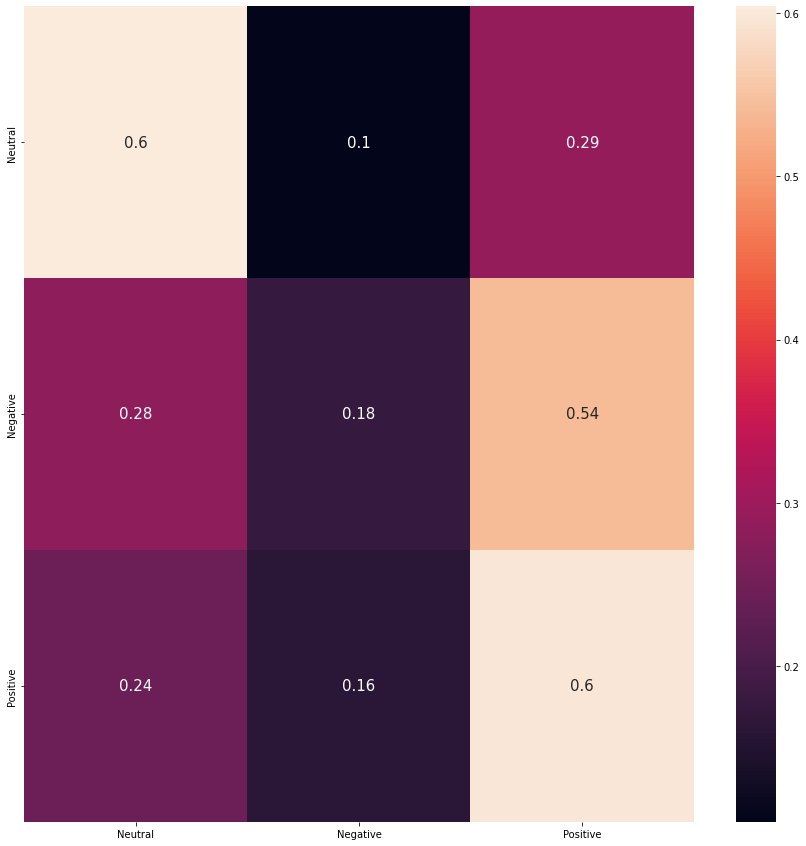

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

# Uchicago

In [ ]:
#convert sentiments to numerical value
labels = np.array(uchicago['sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neutral':
        y.append(0)
    if labels[i] == 'negative':
        y.append(1)
    if labels[i] == 'positive':
        y.append(2)

y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

In [ ]:
#splitting
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(uchicago["text"])
sequences = tokenizer.texts_to_sequences(uchicago["text"])
reddit_posts = pad_sequences(sequences, maxlen=max_len)
print(reddit_posts)

X_train, X_test, y_train, y_test = train_test_split(reddit_posts, labels, random_state = 0)
print (len(X_train),len(X_test),len(y_train),len(y_test)) 

[[   0    0    0 ...    0 1140  537]
 [   0    0    0 ...    1  652   67]
 [   0    0    0 ...    0 1916  695]
 ...
 [   0    0    0 ...    0    0   95]
 [   0    0    0 ... 3131  733  301]
 [   0    0    0 ...  261   16  266]]
19157 6386 19157 6386


In [ ]:
#ltsm model
model = Sequential()
model.add(layers.Embedding(max_words, 40, input_length=max_len))
model.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model.add(layers.Dense(3,activation='softmax'))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#checkpoints enure the best metric is saved during training
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model.fit(X_train, y_train, epochs=30,validation_data=(X_test, y_test),callbacks=[checkpoint2])

Epoch 1/30
599/599 [==============================] - ETA: 0s - loss: 0.7392 - accuracy: 0.6852
Epoch 1: val_accuracy improved from -inf to 0.76605, saving model to best_model2.hdf5
599/599 [==============================] - 97s 155ms/step - loss: 0.7392 - accuracy: 0.6852 - val_loss: 0.5927 - val_accuracy: 0.7661
Epoch 2/30
599/599 [==============================] - ETA: 0s - loss: 0.5221 - accuracy: 0.7879
Epoch 2: val_accuracy improved from 0.76605 to 0.81647, saving model to best_model2.hdf5
599/599 [==============================] - 90s 150ms/step - loss: 0.5221 - accuracy: 0.7879 - val_loss: 0.4739 - val_accuracy: 0.8165
Epoch 3/30
599/599 [==============================] - ETA: 0s - loss: 0.4360 - accuracy: 0.8302
Epoch 3: val_accuracy improved from 0.81647 to 0.83934, saving model to best_model2.hdf5
599/599 [==============================] - 91s 152ms/step - loss: 0.4360 - accuracy: 0.8302 - val_loss: 0.4207 - val_accuracy: 0.8393
Epoch 4/30
599/599 [==========================

In [ ]:
#Try CNN implementation and compare 
from keras import regularizers
model3 = Sequential()
model3.add(layers.Embedding(max_words, 40, input_length=max_len))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.MaxPooling1D(5))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(3,activation='softmax'))
model3.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])
checkpoint3 = ModelCheckpoint("best_model3.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model3.fit(X_train, y_train, epochs=30,validation_data=(X_test, y_test),callbacks=[checkpoint3])

Epoch 1/30
598/599 [============================>.] - ETA: 0s - loss: 0.9843 - acc: 0.6349

599/599 [==============================] - 15s 24ms/step - loss: 0.9841 - acc: 0.6350 - val_loss: 0.7623 - val_acc: 0.7261
Epoch 2/30
598/599 [============================>.] - ETA: 0s - loss: 0.6652 - acc: 0.7547

599/599 [==============================] - 16s 27ms/step - loss: 0.6652 - acc: 0.7548 - val_loss: 0.6178 - val_acc: 0.7733
Epoch 3/30
598/599 [============================>.] - ETA: 0s - loss: 0.5922 - acc: 0.7828

599/599 [==============================] - 16s 26ms/step - loss: 0.5922 - acc: 0.7827 - val_loss: 0.5843 - val_acc: 0.7944
Epoch 4/30
599/599 [==============================] - ETA: 0s - loss: 0.5598 - acc: 0.7984

599/599 [==============================] - 14s 23ms/step - loss: 0.5598 - acc: 0.7984 - val_loss: 0.5694 - val_acc: 0.7967
Epoch 5/30
599/599 [==============================] - ETA: 0s - loss: 0.5411 - acc: 0.8086

599/599 [==============================] - 14s 23ms/step - loss: 0.5411 - acc: 0.8086 - val_loss: 0.5621 - val_acc: 0.7861
Epoch 6/30
599/599 [==============================] - ETA: 0s - loss: 0.5265 - acc: 0.8133

599/599 [==============================] - 14s 23ms/step - loss: 0.5265 - acc: 0.8133 - val_loss: 0.5445 - val_acc: 0.8000
Epoch 7/30
598/599 [============================>.] - ETA: 0s - loss: 0.5154 - acc: 0.8187

599/599 [==============================] - 16s 26ms/step - loss: 0.5155 - acc: 0.8186 - val_loss: 0.5450 - val_acc: 0.7939
Epoch 8/30
597/599 [============================>.] - ETA: 0s - loss: 0.5047 - acc: 0.8226

599/599 [==============================] - 16s 26ms/step - loss: 0.5047 - acc: 0.8225 - val_loss: 0.5398 - val_acc: 0.7982
Epoch 9/30
597/599 [============================>.] - ETA: 0s - loss: 0.4940 - acc: 0.8263

599/599 [==============================] - 14s 24ms/step - loss: 0.4937 - acc: 0.8264 - val_loss: 0.5317 - val_acc: 0.8107
Epoch 10/30
598/599 [============================>.] - ETA: 0s - loss: 0.4810 - acc: 0.8311

599/599 [==============================] - 14s 23ms/step - loss: 0.4810 - acc: 0.8311 - val_loss: 0.5317 - val_acc: 0.8127
Epoch 11/30
598/599 [============================>.] - ETA: 0s - loss: 0.4675 - acc: 0.8381

599/599 [==============================] - 16s 27ms/step - loss: 0.4675 - acc: 0.8380 - val_loss: 0.5271 - val_acc: 0.8085
Epoch 12/30
599/599 [==============================] - ETA: 0s - loss: 0.4538 - acc: 0.8463

599/599 [==============================] - 16s 27ms/step - loss: 0.4538 - acc: 0.8463 - val_loss: 0.5264 - val_acc: 0.8138
Epoch 13/30
599/599 [==============================] - ETA: 0s - loss: 0.4408 - acc: 0.8515

599/599 [==============================] - 14s 24ms/step - loss: 0.4408 - acc: 0.8515 - val_loss: 0.5170 - val_acc: 0.8141
Epoch 14/30
598/599 [============================>.] - ETA: 0s - loss: 0.4287 - acc: 0.8569

599/599 [==============================] - 14s 24ms/step - loss: 0.4287 - acc: 0.8569 - val_loss: 0.4991 - val_acc: 0.8263
Epoch 15/30
598/599 [============================>.] - ETA: 0s - loss: 0.4174 - acc: 0.8623

599/599 [==============================] - 14s 24ms/step - loss: 0.4172 - acc: 0.8624 - val_loss: 0.5062 - val_acc: 0.8232
Epoch 16/30
597/599 [============================>.] - ETA: 0s - loss: 0.4101 - acc: 0.8660

599/599 [==============================] - 16s 27ms/step - loss: 0.4099 - acc: 0.8660 - val_loss: 0.5008 - val_acc: 0.8284
Epoch 17/30
597/599 [============================>.] - ETA: 0s - loss: 0.3997 - acc: 0.8681

599/599 [==============================] - 16s 27ms/step - loss: 0.3998 - acc: 0.8680 - val_loss: 0.5288 - val_acc: 0.8122
Epoch 18/30
599/599 [==============================] - ETA: 0s - loss: 0.3934 - acc: 0.8724

599/599 [==============================] - 14s 24ms/step - loss: 0.3934 - acc: 0.8724 - val_loss: 0.5086 - val_acc: 0.8271
Epoch 19/30
599/599 [==============================] - ETA: 0s - loss: 0.3838 - acc: 0.8781

599/599 [==============================] - 14s 23ms/step - loss: 0.3838 - acc: 0.8781 - val_loss: 0.5107 - val_acc: 0.8229
Epoch 20/30
599/599 [==============================] - ETA: 0s - loss: 0.3748 - acc: 0.8825

599/599 [==============================] - 16s 27ms/step - loss: 0.3748 - acc: 0.8825 - val_loss: 0.5023 - val_acc: 0.8292
Epoch 21/30
598/599 [============================>.] - ETA: 0s - loss: 0.3665 - acc: 0.8855

599/599 [==============================] - 16s 27ms/step - loss: 0.3670 - acc: 0.8855 - val_loss: 0.5113 - val_acc: 0.8257
Epoch 22/30
599/599 [==============================] - ETA: 0s - loss: 0.3596 - acc: 0.8894

599/599 [==============================] - 14s 24ms/step - loss: 0.3596 - acc: 0.8894 - val_loss: 0.5633 - val_acc: 0.8047
Epoch 23/30
597/599 [============================>.] - ETA: 0s - loss: 0.3513 - acc: 0.8947

599/599 [==============================] - 14s 24ms/step - loss: 0.3515 - acc: 0.8946 - val_loss: 0.5219 - val_acc: 0.8310
Epoch 24/30
599/599 [==============================] - ETA: 0s - loss: 0.3435 - acc: 0.8993

599/599 [==============================] - 16s 26ms/step - loss: 0.3435 - acc: 0.8993 - val_loss: 0.5115 - val_acc: 0.8313
Epoch 25/30
598/599 [============================>.] - ETA: 0s - loss: 0.3363 - acc: 0.9042

599/599 [==============================] - 15s 25ms/step - loss: 0.3362 - acc: 0.9042 - val_loss: 0.5181 - val_acc: 0.8257
Epoch 26/30
597/599 [============================>.] - ETA: 0s - loss: 0.3269 - acc: 0.9085

599/599 [==============================] - 16s 27ms/step - loss: 0.3272 - acc: 0.9083 - val_loss: 0.5350 - val_acc: 0.8298
Epoch 27/30
599/599 [==============================] - ETA: 0s - loss: 0.3212 - acc: 0.9124

599/599 [==============================] - 14s 24ms/step - loss: 0.3212 - acc: 0.9124 - val_loss: 0.5215 - val_acc: 0.8382
Epoch 28/30
597/599 [============================>.] - ETA: 0s - loss: 0.3122 - acc: 0.9186

599/599 [==============================] - 15s 25ms/step - loss: 0.3120 - acc: 0.9187 - val_loss: 0.5238 - val_acc: 0.8335
Epoch 29/30
599/599 [==============================] - ETA: 0s - loss: 0.3043 - acc: 0.9216

599/599 [==============================] - 16s 27ms/step - loss: 0.3043 - acc: 0.9216 - val_loss: 0.5784 - val_acc: 0.8050
Epoch 30/30
597/599 [============================>.] - ETA: 0s - loss: 0.2969 - acc: 0.9268

599/599 [==============================] - 16s 27ms/step - loss: 0.2974 - acc: 0.9268 - val_loss: 0.5263 - val_acc: 0.8395


In [ ]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

200/200 - 7s - loss: 1.8498 - accuracy: 0.5326 - 7s/epoch - 34ms/step
Model accuracy:  0.5325712561607361


In [ ]:
predictions = best_model.predict(X_test)

200/200 [==============================] - 5s 26ms/step


<ipython-input-54-1464592c3a2e>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


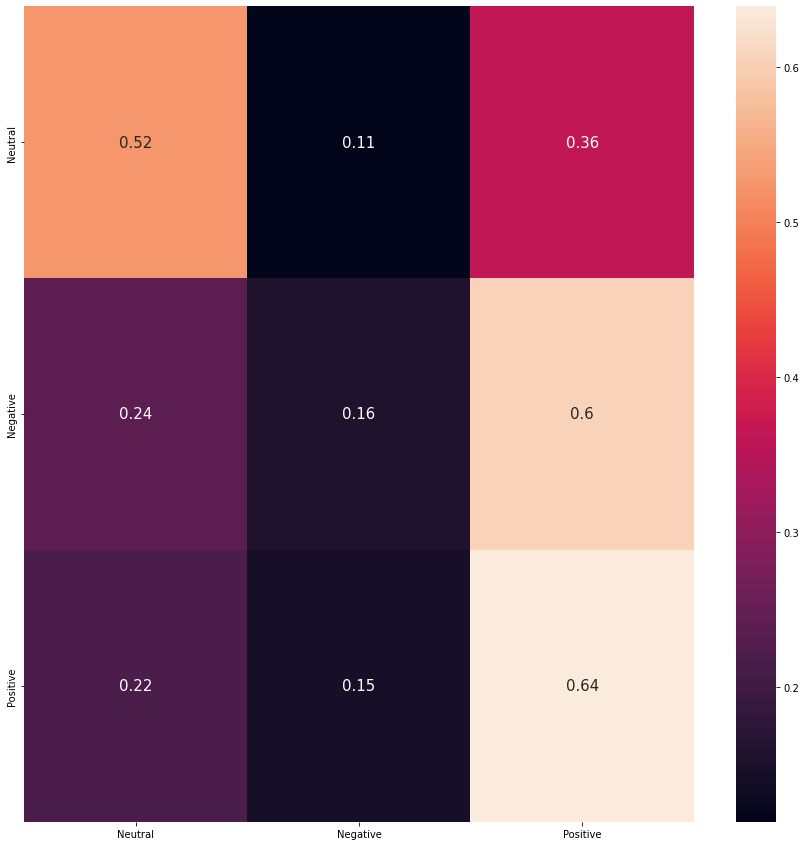

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

# **Cluster 2 - Princeton, Brown, Dartmouth**

In [ ]:
princeton = posts.loc[posts['subreddit_name'] == 'princeton']
brown = posts.loc[posts['subreddit_name'] == 'brownu']
dartmouth = posts.loc[posts['subreddit_name'] == 'dartmouth']

# Princeton

In [ ]:
#convert sentiments to numerical value
labels = np.array(princeton['sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neutral':
        y.append(0)
    if labels[i] == 'negative':
        y.append(1)
    if labels[i] == 'positive':
        y.append(2)

y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

In [ ]:
#splitting
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(princeton["text"])
sequences = tokenizer.texts_to_sequences(princeton["text"])
reddit_posts = pad_sequences(sequences, maxlen=max_len)
print(reddit_posts)

X_train, X_test, y_train, y_test = train_test_split(reddit_posts, labels, random_state = 0)
print (len(X_train),len(X_test),len(y_train),len(y_test)) 

[[   0    0    0 ...  136  213 1269]
 [   0    0    0 ...  293  890   52]
 [   0    0    0 ...  195 1570  864]
 ...
 [   0    0    0 ...  210   75  916]
 [   0    0    0 ...   88  679   37]
 [   0    0    0 ...  790  760   40]]
6619 2207 6619 2207


In [ ]:
#ltsm model
model = Sequential()
model.add(layers.Embedding(max_words, 40, input_length=max_len))
model.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model.add(layers.Dense(3,activation='softmax'))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#checkpoints enure the best metric is saved during training
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model.fit(X_train, y_train, epochs=30,validation_data=(X_test, y_test),callbacks=[checkpoint2])

Epoch 1/30
207/207 [==============================] - ETA: 0s - loss: 0.7989 - accuracy: 0.6771
Epoch 1: val_accuracy improved from -inf to 0.72859, saving model to best_model2.hdf5
207/207 [==============================] - 36s 148ms/step - loss: 0.7989 - accuracy: 0.6771 - val_loss: 0.7017 - val_accuracy: 0.7286
Epoch 2/30
207/207 [==============================] - ETA: 0s - loss: 0.6431 - accuracy: 0.7362
Epoch 2: val_accuracy improved from 0.72859 to 0.76756, saving model to best_model2.hdf5
207/207 [==============================] - 34s 166ms/step - loss: 0.6431 - accuracy: 0.7362 - val_loss: 0.5853 - val_accuracy: 0.7676
Epoch 3/30
207/207 [==============================] - ETA: 0s - loss: 0.5494 - accuracy: 0.7846
Epoch 3: val_accuracy improved from 0.76756 to 0.77889, saving model to best_model2.hdf5
207/207 [==============================] - 30s 143ms/step - loss: 0.5494 - accuracy: 0.7846 - val_loss: 0.5518 - val_accuracy: 0.7789
Epoch 4/30
207/207 [==========================

In [ ]:
#Try CNN implementation and compare 
from keras import regularizers
model3 = Sequential()
model3.add(layers.Embedding(max_words, 40, input_length=max_len))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.MaxPooling1D(5))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(3,activation='softmax'))
model3.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])
checkpoint3 = ModelCheckpoint("best_model3.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model3.fit(X_train, y_train, epochs=30,validation_data=(X_test, y_test),callbacks=[checkpoint3])

Epoch 1/30
205/207 [============================>.] - ETA: 0s - loss: 1.1610 - acc: 0.6506

207/207 [==============================] - 6s 25ms/step - loss: 1.1570 - acc: 0.6516 - val_loss: 0.8799 - val_acc: 0.6661
Epoch 2/30
207/207 [==============================] - ETA: 0s - loss: 0.8106 - acc: 0.6876

207/207 [==============================] - 5s 24ms/step - loss: 0.8106 - acc: 0.6876 - val_loss: 0.6991 - val_acc: 0.7802
Epoch 3/30
206/207 [============================>.] - ETA: 0s - loss: 0.6432 - acc: 0.7928

207/207 [==============================] - 6s 28ms/step - loss: 0.6432 - acc: 0.7924 - val_loss: 0.6130 - val_acc: 0.8065
Epoch 4/30
207/207 [==============================] - ETA: 0s - loss: 0.5827 - acc: 0.8187

207/207 [==============================] - 6s 27ms/step - loss: 0.5827 - acc: 0.8187 - val_loss: 0.5782 - val_acc: 0.8115
Epoch 5/30
207/207 [==============================] - ETA: 0s - loss: 0.5486 - acc: 0.8275

207/207 [==============================] - 5s 26ms/step - loss: 0.5486 - acc: 0.8275 - val_loss: 0.5564 - val_acc: 0.8160
Epoch 6/30
206/207 [============================>.] - ETA: 0s - loss: 0.5233 - acc: 0.8348

207/207 [==============================] - 6s 30ms/step - loss: 0.5231 - acc: 0.8350 - val_loss: 0.5590 - val_acc: 0.8101
Epoch 7/30
205/207 [============================>.] - ETA: 0s - loss: 0.5027 - acc: 0.8380

207/207 [==============================] - 5s 24ms/step - loss: 0.5028 - acc: 0.8379 - val_loss: 0.5374 - val_acc: 0.8156
Epoch 8/30
205/207 [============================>.] - ETA: 0s - loss: 0.4853 - acc: 0.8447

207/207 [==============================] - 5s 24ms/step - loss: 0.4851 - acc: 0.8445 - val_loss: 0.5522 - val_acc: 0.8133
Epoch 9/30
207/207 [==============================] - ETA: 0s - loss: 0.4730 - acc: 0.8456

207/207 [==============================] - 5s 24ms/step - loss: 0.4730 - acc: 0.8456 - val_loss: 0.5366 - val_acc: 0.8192
Epoch 10/30
207/207 [==============================] - ETA: 0s - loss: 0.4624 - acc: 0.8507

207/207 [==============================] - 5s 24ms/step - loss: 0.4624 - acc: 0.8507 - val_loss: 0.5406 - val_acc: 0.8151
Epoch 11/30
206/207 [============================>.] - ETA: 0s - loss: 0.4514 - acc: 0.8556

207/207 [==============================] - 5s 24ms/step - loss: 0.4514 - acc: 0.8556 - val_loss: 0.5363 - val_acc: 0.8188
Epoch 12/30
206/207 [============================>.] - ETA: 0s - loss: 0.4427 - acc: 0.8536

207/207 [==============================] - 7s 32ms/step - loss: 0.4431 - acc: 0.8536 - val_loss: 0.5415 - val_acc: 0.8206
Epoch 13/30
207/207 [==============================] - ETA: 0s - loss: 0.4340 - acc: 0.8596

207/207 [==============================] - 5s 24ms/step - loss: 0.4340 - acc: 0.8596 - val_loss: 0.5484 - val_acc: 0.8256
Epoch 14/30
206/207 [============================>.] - ETA: 0s - loss: 0.4254 - acc: 0.8630

207/207 [==============================] - 5s 24ms/step - loss: 0.4255 - acc: 0.8630 - val_loss: 0.5467 - val_acc: 0.8233
Epoch 15/30
206/207 [============================>.] - ETA: 0s - loss: 0.4155 - acc: 0.8692

207/207 [==============================] - 5s 25ms/step - loss: 0.4154 - acc: 0.8692 - val_loss: 0.5690 - val_acc: 0.8206
Epoch 16/30
207/207 [==============================] - ETA: 0s - loss: 0.4055 - acc: 0.8717

207/207 [==============================] - 7s 32ms/step - loss: 0.4055 - acc: 0.8717 - val_loss: 0.5451 - val_acc: 0.8219
Epoch 17/30
206/207 [============================>.] - ETA: 0s - loss: 0.3960 - acc: 0.8739

207/207 [==============================] - 5s 25ms/step - loss: 0.3960 - acc: 0.8738 - val_loss: 0.5550 - val_acc: 0.8274
Epoch 18/30
206/207 [============================>.] - ETA: 0s - loss: 0.3885 - acc: 0.8783

207/207 [==============================] - 5s 25ms/step - loss: 0.3893 - acc: 0.8779 - val_loss: 0.5654 - val_acc: 0.8224
Epoch 19/30
207/207 [==============================] - ETA: 0s - loss: 0.3801 - acc: 0.8840

207/207 [==============================] - 5s 25ms/step - loss: 0.3801 - acc: 0.8840 - val_loss: 0.5692 - val_acc: 0.8165
Epoch 20/30
205/207 [============================>.] - ETA: 0s - loss: 0.3722 - acc: 0.8887

207/207 [==============================] - 5s 24ms/step - loss: 0.3716 - acc: 0.8891 - val_loss: 0.5764 - val_acc: 0.8237
Epoch 21/30
205/207 [============================>.] - ETA: 0s - loss: 0.3639 - acc: 0.8928

207/207 [==============================] - 5s 25ms/step - loss: 0.3645 - acc: 0.8924 - val_loss: 0.5829 - val_acc: 0.8165
Epoch 22/30
205/207 [============================>.] - ETA: 0s - loss: 0.3559 - acc: 0.8973

207/207 [==============================] - 5s 25ms/step - loss: 0.3563 - acc: 0.8973 - val_loss: 0.5894 - val_acc: 0.8179
Epoch 23/30
206/207 [============================>.] - ETA: 0s - loss: 0.3481 - acc: 0.9040

207/207 [==============================] - 5s 25ms/step - loss: 0.3483 - acc: 0.9038 - val_loss: 0.5974 - val_acc: 0.8206
Epoch 24/30
207/207 [==============================] - ETA: 0s - loss: 0.3388 - acc: 0.9080

207/207 [==============================] - 5s 25ms/step - loss: 0.3388 - acc: 0.9080 - val_loss: 0.6118 - val_acc: 0.8201
Epoch 25/30
207/207 [==============================] - ETA: 0s - loss: 0.3307 - acc: 0.9131

207/207 [==============================] - 5s 25ms/step - loss: 0.3307 - acc: 0.9131 - val_loss: 0.6468 - val_acc: 0.8156
Epoch 26/30
207/207 [==============================] - ETA: 0s - loss: 0.3220 - acc: 0.9157

207/207 [==============================] - 5s 25ms/step - loss: 0.3220 - acc: 0.9157 - val_loss: 0.6264 - val_acc: 0.8151
Epoch 27/30
205/207 [============================>.] - ETA: 0s - loss: 0.3148 - acc: 0.9198

207/207 [==============================] - 5s 25ms/step - loss: 0.3146 - acc: 0.9201 - val_loss: 0.6316 - val_acc: 0.8174
Epoch 28/30
206/207 [============================>.] - ETA: 0s - loss: 0.3038 - acc: 0.9238

207/207 [==============================] - 5s 25ms/step - loss: 0.3050 - acc: 0.9233 - val_loss: 0.6716 - val_acc: 0.8029
Epoch 29/30
206/207 [============================>.] - ETA: 0s - loss: 0.2975 - acc: 0.9302

207/207 [==============================] - 7s 32ms/step - loss: 0.2974 - acc: 0.9300 - val_loss: 0.6333 - val_acc: 0.7970
Epoch 30/30
207/207 [==============================] - ETA: 0s - loss: 0.2882 - acc: 0.9328

207/207 [==============================] - 5s 25ms/step - loss: 0.2882 - acc: 0.9328 - val_loss: 0.6686 - val_acc: 0.8206


In [ ]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

69/69 - 2s - loss: 1.8382 - accuracy: 0.5374 - 2s/epoch - 24ms/step
Model accuracy:  0.5373810529708862


In [ ]:
predictions = best_model.predict(X_test)

69/69 [==============================] - 2s 27ms/step


<ipython-input-62-1464592c3a2e>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


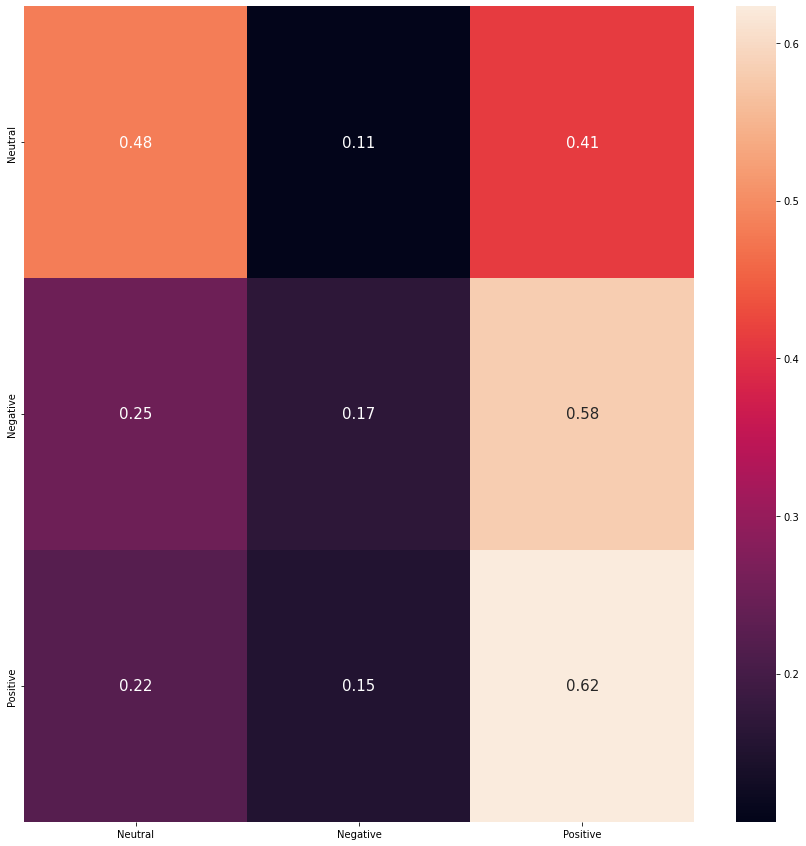

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})


# B. Brown University

In [ ]:
#convert sentiments to numerical value
labels = np.array(brown['sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neutral':
        y.append(0)
    if labels[i] == 'negative':
        y.append(1)
    if labels[i] == 'positive':
        y.append(2)

y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

In [ ]:
#splitting
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(brown["text"])
sequences = tokenizer.texts_to_sequences(brown["text"])
reddit_posts = pad_sequences(sequences, maxlen=max_len)
print(reddit_posts)

X_train, X_test, y_train, y_test = train_test_split(reddit_posts, labels, random_state = 0)
print (len(X_train),len(X_test),len(y_train),len(y_test)) 

[[   0    0    0 ... 1856 3329 1586]
 [   0    0    0 ...  161 4227 3723]
 [   0    0    0 ...   53 1773   94]
 ...
 [   0    0    0 ...  179   12   19]
 [   0    0    0 ...  597   73 1025]
 [   0    0    0 ...  621   10   19]]
9588 3196 9588 3196


In [ ]:
#ltsm model
model = Sequential()
model.add(layers.Embedding(max_words, 40, input_length=max_len))
model.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model.add(layers.Dense(3,activation='softmax'))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#checkpoints enure the best metric is saved during training
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint2])

In [ ]:
#Try CNN implementation and compare 
from keras import regularizers
model3 = Sequential()
model3.add(layers.Embedding(max_words, 40, input_length=max_len))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.MaxPooling1D(5))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(3,activation='softmax'))
model3.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])
checkpoint3 = ModelCheckpoint("best_model3.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model3.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint3])

In [ ]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

In [ ]:
predictions = best_model.predict(X_test)

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})


# C. Dartmouth

In [ ]:
#convert sentiments to numerical value
labels = np.array(dartmouth['sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neutral':
        y.append(0)
    if labels[i] == 'negative':
        y.append(1)
    if labels[i] == 'positive':
        y.append(2)

y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

In [ ]:
#splitting
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(dartmouth["text"])
sequences = tokenizer.texts_to_sequences(dartmouth["text"])
reddit_posts = pad_sequences(sequences, maxlen=max_len)
print(reddit_posts)

X_train, X_test, y_train, y_test = train_test_split(reddit_posts, labels, random_state = 0)
print (len(X_train),len(X_test),len(y_train),len(y_test)) 

In [ ]:
#ltsm model
model = Sequential()
model.add(layers.Embedding(max_words, 40, input_length=max_len))
model.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model.add(layers.Dense(3,activation='softmax'))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#checkpoints enure the best metric is saved during training
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint2])

In [ ]:
#Try CNN implementation and compare 
from keras import regularizers
model3 = Sequential()
model3.add(layers.Embedding(max_words, 40, input_length=max_len))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.MaxPooling1D(5))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(3,activation='softmax'))
model3.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])
checkpoint3 = ModelCheckpoint("best_model3.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model3.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint3])

In [ ]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

In [ ]:
predictions = best_model.predict(X_test)

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})
